In [1]:
import sys
import os
import pandas as pd


In [2]:
sys.path.append('..')

In [3]:
from icenode.train_icenode_2lr import ICENODE
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN

%load_ext autoreload
%autoreload 2

/home/asem/.conda/envs/icenode/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


## Define Directories

In [4]:
HOME = os.environ.get('HOME')

# MIMIC-III Dataset Directory
mimic3_dir = f'{HOME}/GP/ehr-data/mimic3-transforms'

# ICE-NODE/M trained on MIMIC-III training partition (70%)
icenode_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.09.aM3_icenode_2lr_M/trial_686'

# RETAIN trained on MIMIC-III training partition (70%)
# retain_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_retain_M/frozen_trial_142'

# # GRU=GRAM/M trained on MIMIC-III training partition (70%)
# gru_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_gram_M/frozen_trial_615'

# # GRAM=GRAM/G trained on MIMIC-III training partition (70%)
# gram_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_gram_G/frozen_trial_442'

## Patient Interface for each Model

In [24]:
icnode_patient_interface = ICENODE.create_patient_interface(mimic3_dir, 'M3')

## Dataset Partitioning

In [6]:
import random

# seed 42 is used in all our experiments in this work.
rng = random.Random(42)
subjects_id = list(icnode_patient_interface.subjects.keys())
rng.shuffle(subjects_id)

# splits = train:val:test = 0.7:.15:.15
splits = int(.7 * len(subjects_id)), int(.85 * len(subjects_id))

train_ids = subjects_id[:splits[0]]
valid_ids = subjects_id[splits[0]:splits[1]]
test_ids = subjects_id[splits[1]:]

## Load Configs and Trained Params

In [7]:
from icenode.utils import load_config, load_params

icenode_config = load_config(f'{icenode_m3_dir}/config.json')
icenode_params = load_params(f'{icenode_m3_dir}/step0100_params.pickle')

# retain_config = load_config(f'{retain_m3_dir}/config.json')
# retain_params = load_params(f'{retain_m3_dir}/step0100_params.pickle')

# gru_config = load_config(f'{gru_m3_dir}/config.json')
# gru_params = load_params(f'{gru_m3_dir}/step0100_params.pickle')

# gram_config = load_config(f'{gram_m3_dir}/config.json')
# gram_params = load_params(f'{gram_m3_dir}/step0100_params.pickle')

## Create Model Objects

In [8]:
icenode_config

{'emb': {'diag': {'embeddings_dim': 270}, 'kind': 'matrix'},
 'model': {'ode_dyn': 'mlp',
  'ode_init_var': 1.070451695544183e-06,
  'ode_with_bias': False,
  'state_size': 30,
  'timescale': 60},
 'training': {'batch_size': 17,
  'decay_rate1': 0.14521935532706035,
  'decay_rate2': 0.5100323575807254,
  'epochs': 20,
  'loss_mixing': {'L_dyn': 0, 'L_l1': 0, 'L_l2': 0},
  'lr1': 1.0097133769305705e-05,
  'lr2': 0.0013079966926765893,
  'optimizer': 'adam'}}

In [9]:
icenode = ICENODE.create_model(icenode_config, icnode_patient_interface, train_ids, None)
model_state = icenode.init_with_params(icenode_config, icenode_params)
# retain = RETAIN.create_model(retain_config, retain_patient_interface, train_ids, None)
# gru = GRAM.create_model(gru_config, gram_patient_interface, train_ids, None)
# gram = GRAM.create_model(gram_config, gram_patient_interface, train_ids, None)

In [10]:
code_partitions = ICENODE.code_partitions(icnode_patient_interface, train_ids) 

In [11]:
from icenode.metrics import evaluation_table
res = icenode.eval(model_state, test_ids)

In [12]:
eval_df, _ = evaluation_table({'TST': res}, code_partitions)

/home/asem/.conda/envs/icenode/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5338: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


In [13]:
eval_df

(                           TST
 Kfe               5.122400e+01
 MACRO-AUC         9.442196e-01
 MICRO-AUC         9.457941e-01
 accuracy          8.398458e-01
 admissions_count  1.009000e+03
 dyn_loss          8.451658e-10
 f1-score          1.546134e-01
 fn                1.817208e-03
 fp                1.583370e-01
 loss              7.756717e-02
 nfe_per_week      8.136864e-01
 npv               9.978027e-01
 odeint_weeks      6.295300e+04
 pre_ACC-P0        1.553047e-01
 pre_ACC-P1        3.643962e-01
 pre_ACC-P2        4.571783e-01
 pre_ACC-P3        7.459077e-01
 pre_ACC-P4        9.367572e-01
 precision         8.466389e-02
 prediction_loss   7.756717e-02
 recall            8.896158e-01
 specificity       8.390128e-01
 tn                8.252004e-01
 tp                1.464536e-02,
 {'TST_loss': 0.07756716758012772,
  'TST_prediction_loss': 0.07756716758012772,
  'TST_dyn_loss': 8.4516582621319e-10,
  'TST_admissions_count': 1009.0,
  'TST_odeint_weeks': 62953.0,
  'TST_nfe_per

## Analyse AUC for Each Admission in the Test Partition

In [83]:
icenode_auc_df = icenode.admissions_auc_scores(model_state, test_ids)

In [84]:
icenode_auc_df

,SUBJECT_ID,HADM_ID,HADM_IDX,AUC,N_CODES,TIME,INTERVALS,LOS,R/T,NFE
0,19842,169734,0,0.967812,9.0,412.5,412.5,3.5,2.2486747e-15,62.0
1,19842,186772,1,0.962553,16.0,433.5,21.0,7.5,1.2200527e-15,26.0
2,19842,180229,2,0.973073,9.0,448.5,15.0,3.5,3.0741945e-15,26.0
3,19842,122439,3,0.970480,13.0,509.5,61.0,7.5,1.6864148e-15,32.0
4,19842,163738,4,0.990412,13.0,552.5,43.0,5.5,2.7500403e-15,32.0
...,...,...,...,...,...,...,...,...,...,...
1004,26421,192868,1,0.969256,6.0,278.5,186.0,3.5,2.090492e-15,50.0
1005,2558,105758,0,0.891569,11.0,59.5,59.5,4.5,9.334396e-16,32.0
1006,2558,194247,1,0.974270,8.0,70.5,11.0,4.5,2.2445814e-15,20.0
1007,10832,196835,0,0.968586,9.0,647.5,647.5,8.5,4.367973e-15,68.0


In [85]:
auc_subject = icenode_auc_df.groupby('SUBJECT_ID').agg({'AUC': 'mean', 'N_CODES': ['min', 'max', 'mean', 'median'], 'INTERVALS': ['mean'], 'R/T': ['min', 'max', 'mean'] })

In [94]:
auc_subject['R/T']['mean'].max()

1.7346060207414544e-14

In [109]:
interest_subjects =  auc_subject[(auc_subject.AUC['mean'] > 0.95) & (auc_subject.N_CODES['max'] < 10)]
interest_subjects

AUC N_CODES                  INTERVALS            R/T  \
                mean     min  max mean median      mean            min   
SUBJECT_ID                                                               
154         0.991300     5.0  7.0  6.0    6.0   1824.75   9.115221e-16   
299         1.000000     1.0  1.0  1.0    1.0      7.50  3.9807457e-16   
630         0.965336     9.0  9.0  9.0    9.0    229.50   2.273799e-15   
1080        0.998619     3.0  3.0  3.0    3.0      5.50  7.8898197e-16   
1935        0.969153     3.0  3.0  3.0    3.0     50.50  3.8476368e-16   
...              ...     ...  ...  ...    ...       ...            ...   
84519       0.956670     9.0  9.0  9.0    9.0    373.50  1.4315721e-15   
90451       0.985714     7.0  7.0  7.0    7.0   1384.50  5.3626026e-16   
91469       0.960388     5.0  5.0  5.0    5.0     19.50   4.715053e-16   
94446       0.985516     7.0  7.0  7.0    7.0    427.50  1.4437467e-15   
96491       0.993113     1.0  1.0  1.0    1.0     86.50  2.9502488e-16   

                                         
                      max          mean  
SUBJECT_ID                               
154         1.8533517e-15  1.382437e-15  
299         3.9807457e-16  3.980746e-16  
630          2.273799e-15  2.273799e-15  
1080        7.8898197e-16  7.889820e-16  
1935        3.8476368e-16  3.847637e-16  
...                   ...           ...  
84519       1.4315721e-15  1.431572e-15  
90451       5.3626026e-16  5.362603e-16  
91469        4.715053e-16  4.715053e-16  
94446       1.4437467e-15  1.443747e-15  
96491       2.9502488e-16  2.950249e-16  

[141 rows x 9 columns]

In [110]:
interest_subjects_l = interest_subjects.index.tolist()
interest_subjects_l

[154,
 299,
 630,
 1080,
 1935,
 1936,
 3191,
 3365,
 3657,
 4571,
 4831,
 4910,
 5321,
 5620,
 5675,
 5944,
 6038,
 6502,
 6706,
 6711,
 6783,
 6920,
 6969,
 7102,
 7301,
 7382,
 7534,
 7671,
 7726,
 7731,
 7837,
 8374,
 9224,
 9480,
 9486,
 9602,
 9923,
 10226,
 10376,
 11045,
 11338,
 11474,
 11479,
 11604,
 11677,
 12449,
 12564,
 12582,
 12773,
 13052,
 13179,
 13208,
 13289,
 13528,
 14106,
 14606,
 14749,
 14835,
 14837,
 15226,
 15341,
 15453,
 15508,
 15686,
 15732,
 15905,
 16752,
 16934,
 17132,
 17531,
 17548,
 17794,
 18454,
 18622,
 18689,
 19488,
 19772,
 20088,
 20173,
 20217,
 20471,
 20552,
 20749,
 20776,
 20862,
 20993,
 21297,
 21454,
 22206,
 22600,
 22800,
 22896,
 24280,
 25143,
 25148,
 25297,
 25473,
 25801,
 25929,
 26228,
 26698,
 26727,
 27462,
 29365,
 29453,
 29926,
 30243,
 30737,
 30927,
 31501,
 31920,
 32130,
 32192,
 32465,
 40405,
 42210,
 42697,
 44413,
 47257,
 48025,
 53632,
 56179,
 58617,
 59198,
 59457,
 60226,
 67265,
 69144,
 71527,
 72940,


In [16]:
icenode_auc_df.to_csv('icenode_auc_df.csv')

In [17]:
icenode_auc_df['NFE'] = icenode_auc_df['NFE'].astype(int)
icenode_auc_df['NFEpday'] = icenode_auc_df['NFE'].astype(int) / icenode_auc_df['INTERVALS']
icenode_auc_df['N_CODES'] = icenode_auc_df['N_CODES'].astype(int)


In [18]:
icenode_auc_df.dtypes

SUBJECT_ID      int64
HADM_ID         int64
HADM_IDX        int64
AUC           float64
N_CODES         int64
TIME          float64
INTERVALS     float64
LOS           float64
NFE             int64
NFEpday       float64
dtype: object

In [19]:
icenode_stat = icenode_auc_df[['AUC', 'N_CODES', 'INTERVALS', 'LOS', 'NFE', 'NFEpday']]

In [20]:
icenode_stat

,AUC,N_CODES,INTERVALS,LOS,NFE,NFEpday
0,0.967812,9,412.5,3.5,62,0.150303
1,0.962553,16,21.0,7.5,26,1.238095
2,0.973073,9,15.0,3.5,26,1.733333
3,0.970480,13,61.0,7.5,32,0.524590
4,0.990412,13,43.0,5.5,32,0.744186
...,...,...,...,...,...,...
1004,0.969256,6,186.0,3.5,50,0.268817
1005,0.891569,11,59.5,4.5,32,0.537815
1006,0.974270,8,11.0,4.5,20,1.818182
1007,0.968586,9,647.5,8.5,68,0.105019


In [101]:
import seaborn as sns
# sns.pairplot(icenode_stat)

In [149]:
trajectory = icenode.sample_trajectory(model_state, interest_subjects_l, 2)

/home/asem/GP/ICENODE/analysis/../icenode/train_icenode_tl.py:410: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos[[top10_idx]] = 1


In [144]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [150]:
data = {}
for i, traj in trajectory.items():
    
    ccs_codes, ccs_idx = icnode_patient_interface.diag_ccs_history(i)
    hist_idx = np.array(list(ccs_idx))
    t = traj['t']
    d = np.log(traj['d'])
    tp10 = traj['tp10']
    
    logprob = []
    time = []
    code = []
    tp = []
    for ccs_c, ccs_i in zip(ccs_codes, ccs_idx):
        time.append(t)
        code.extend([ccs_c]*len(t))
        logprob.append(d[:, ccs_i])
        tp.append(tp10[:, ccs_i])
    
    logprob = np.hstack(logprob)
    time = np.hstack(time)
    tp = np.hstack(tp)
    data[i] = pd.DataFrame({'t': time, r'$\log\hat{v}$': logprob, 'code': code, 'tp': tp})
    

In [151]:
trajectory.keys()

dict_keys([154, 299, 630, 1080, 1935, 1936, 3191, 3365, 3657, 4571, 4831, 4910, 5321, 5620, 5675, 5944, 6038, 6502, 6706, 6711, 6783, 6920, 6969, 7102, 7301, 7382, 7534, 7671, 7726, 7731, 7837, 8374, 9224, 9480, 9486, 9602, 9923, 10226, 10376, 11045, 11338, 11474, 11479, 11604, 11677, 12449, 12564, 12582, 12773, 13052, 13179, 13208, 13289, 13528, 14106, 14606, 14749, 14835, 14837, 15226, 15341, 15453, 15508, 15686, 15732, 15905, 16752, 16934, 17132, 17531, 17548, 17794, 18454, 18622, 18689, 19488, 19772, 20088, 20173, 20217, 20471, 20552, 20749, 20776, 20862, 20993, 21297, 21454, 22206, 22600, 22800, 22896, 24280, 25143, 25148, 25297, 25473, 25801, 25929, 26228, 26698, 26727, 27462, 29365, 29453, 29926, 30243, 30737, 30927, 31501, 31920, 32130, 32192, 32465, 40405, 42210, 42697, 44413, 47257, 48025, 53632, 56179, 58617, 59198, 59457, 60226, 67265, 69144, 71527, 72940, 74252, 75320, 79977, 81209, 81240, 83466, 84519, 90451, 91469, 94446, 96491])

/tmp/ipykernel_6540/3938612687.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


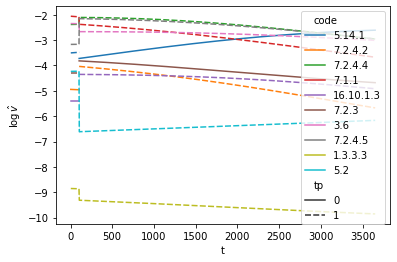

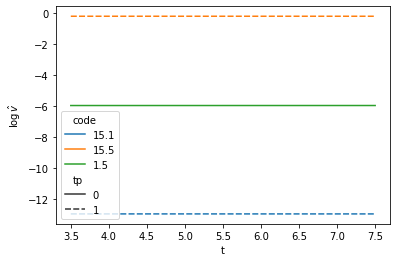

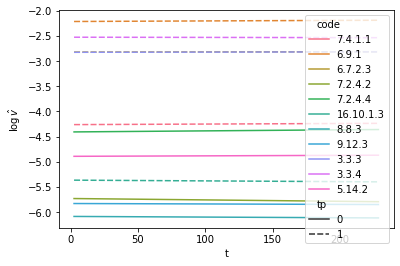

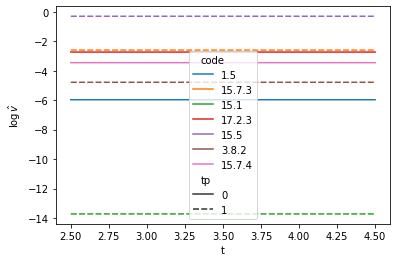

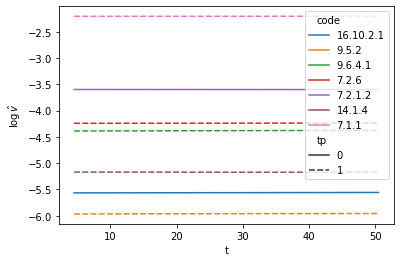

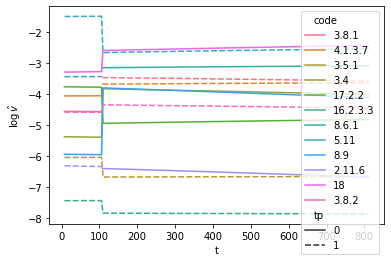

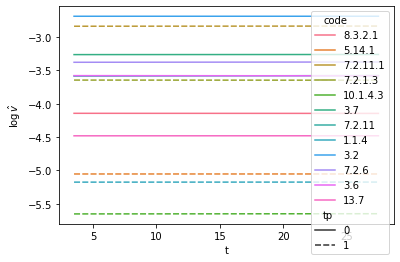

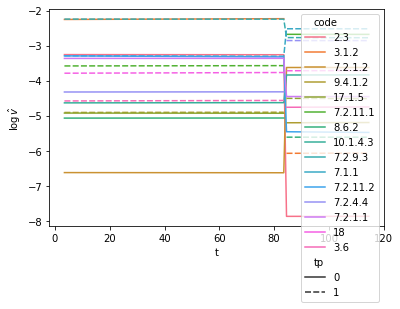

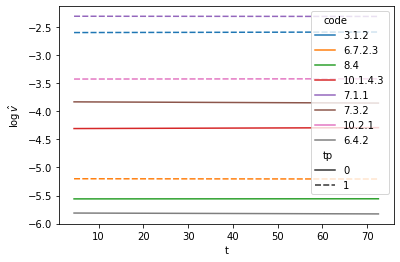

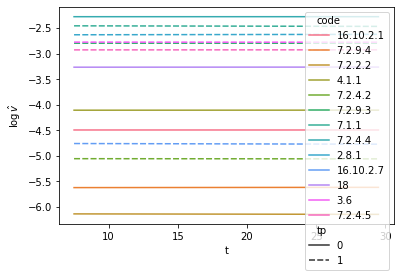

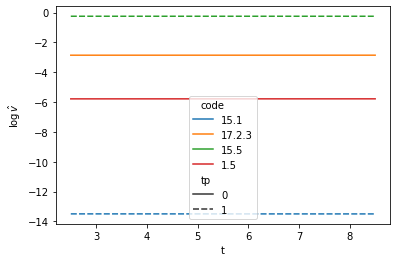

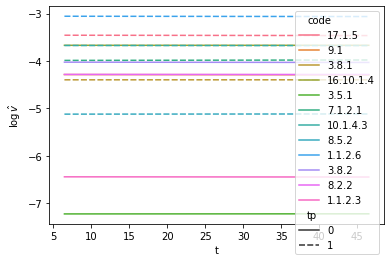

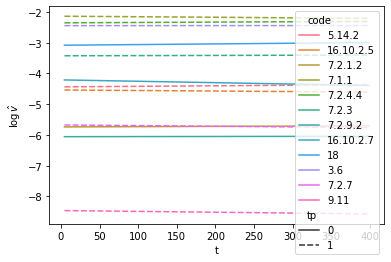

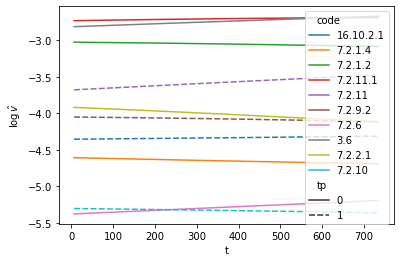

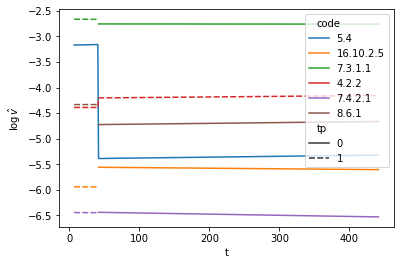

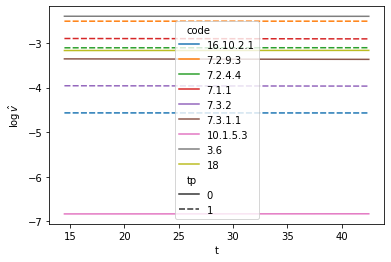

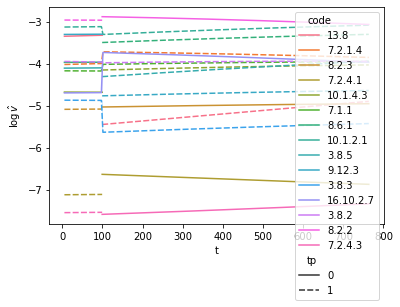

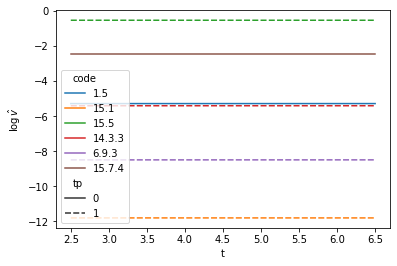

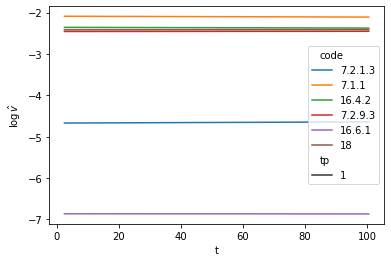

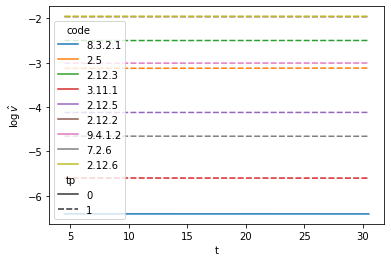

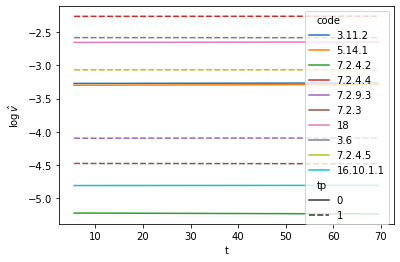

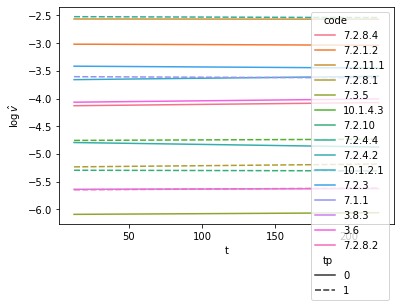

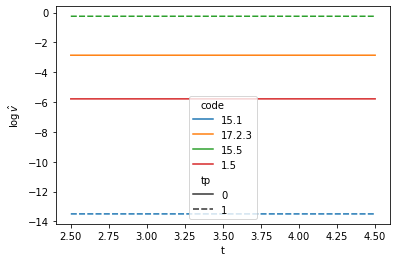

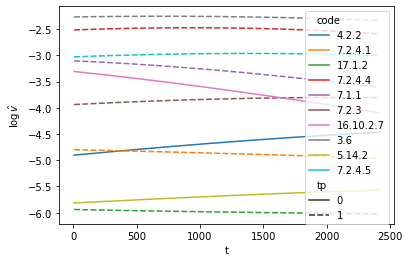

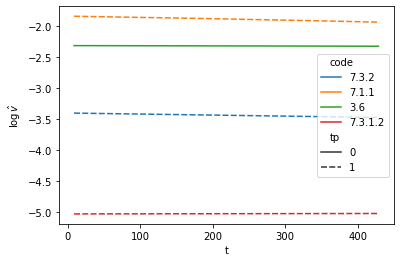

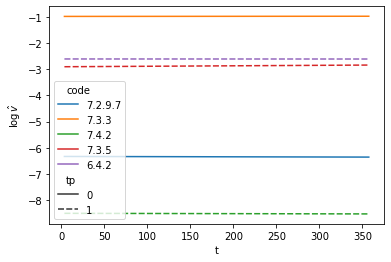

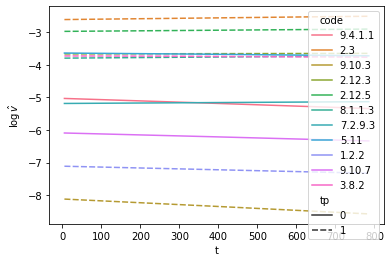

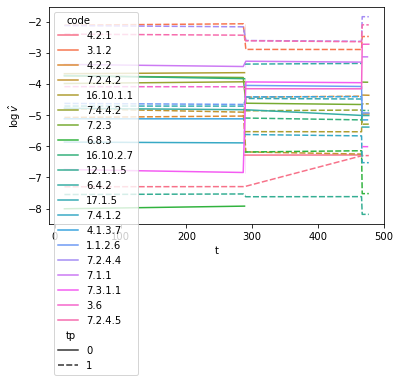

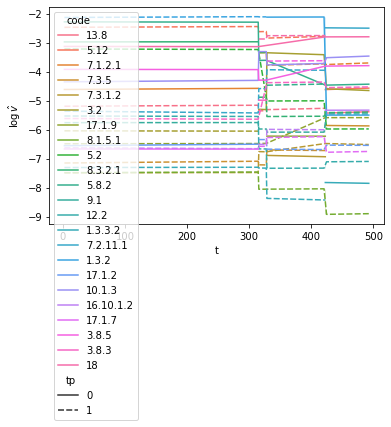

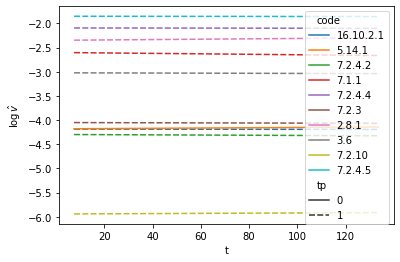

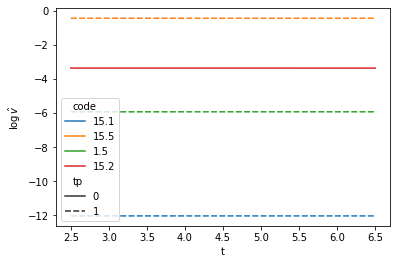

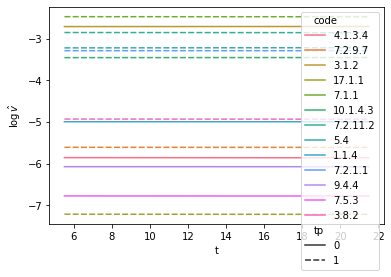

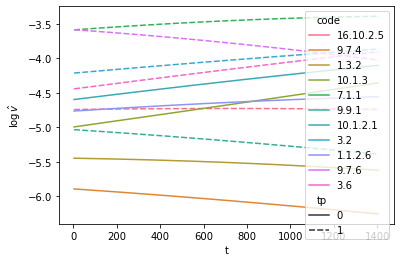

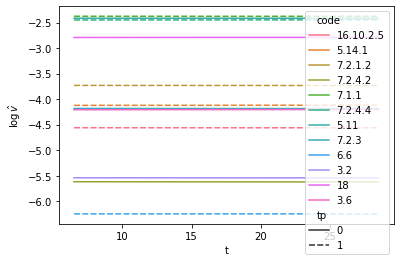

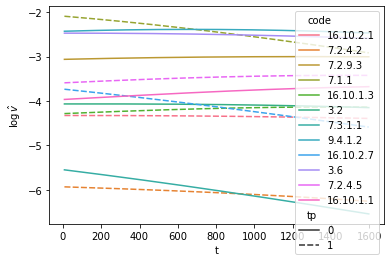

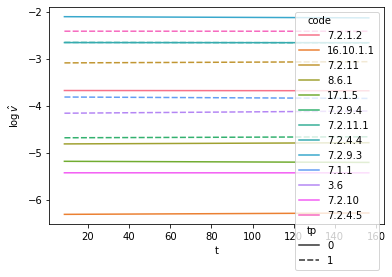

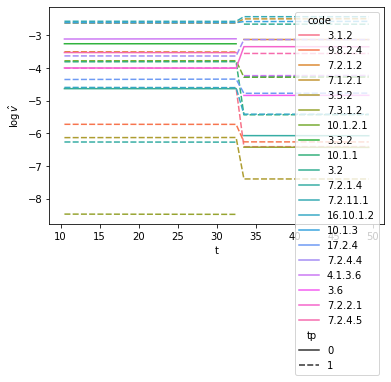

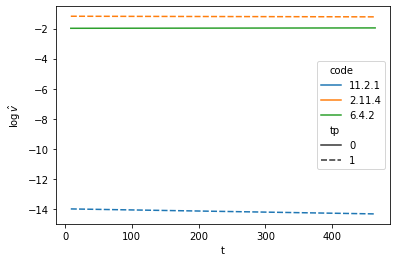

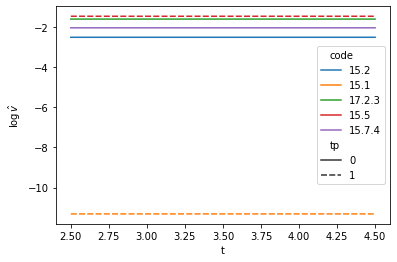

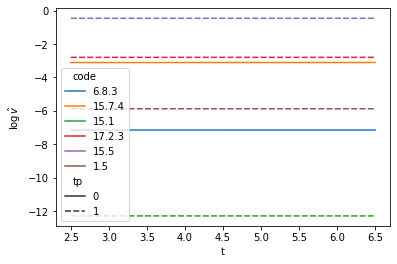

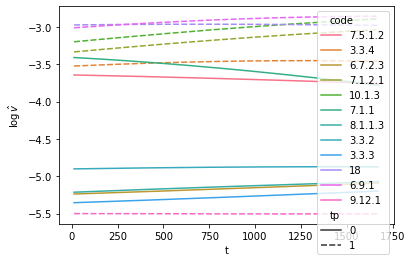

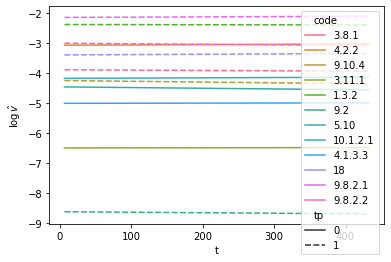

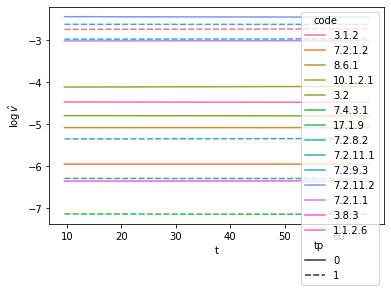

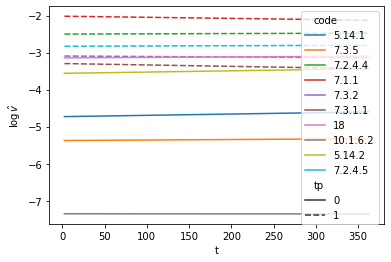

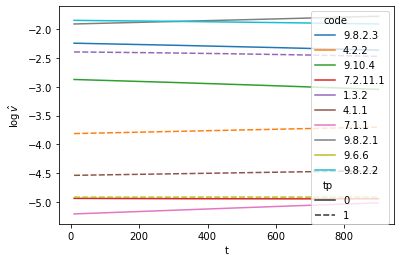

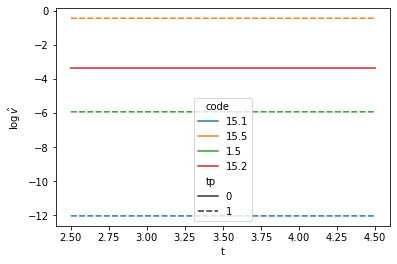

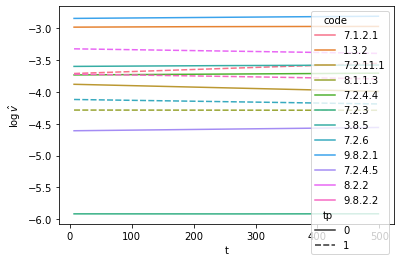

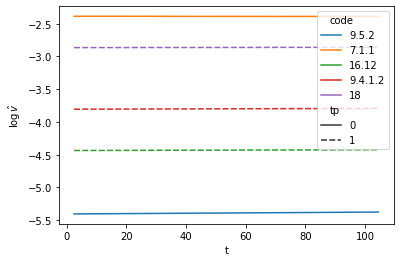

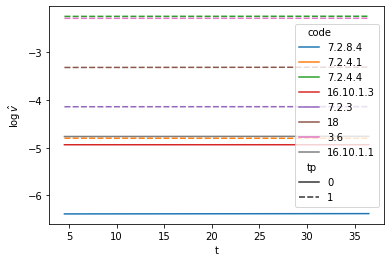

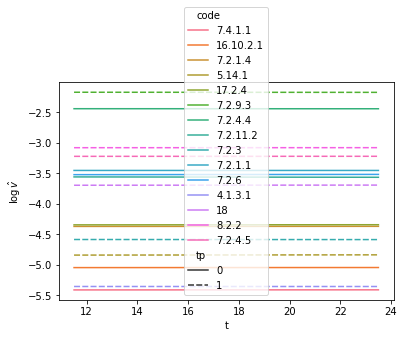

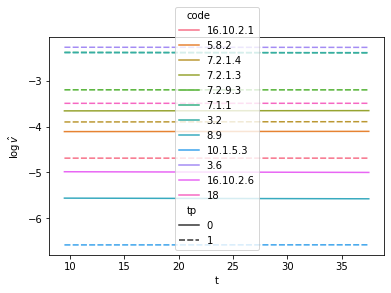

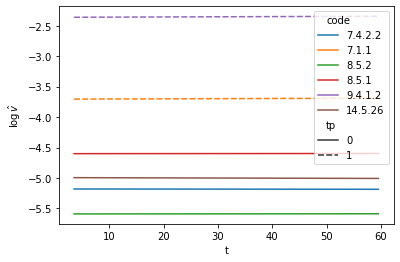

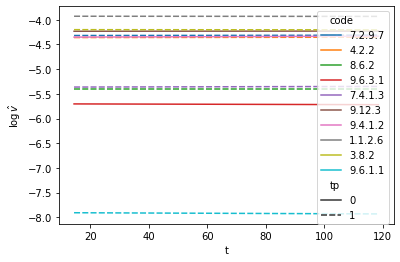

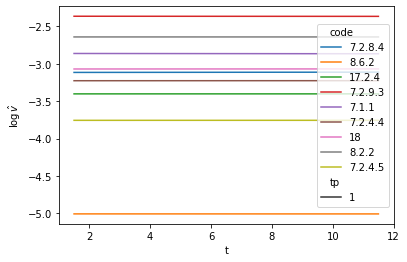

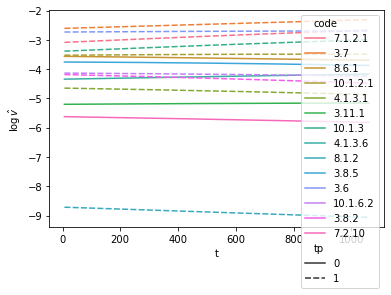

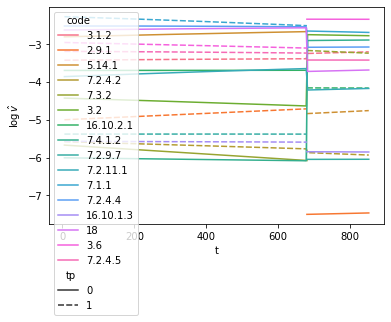

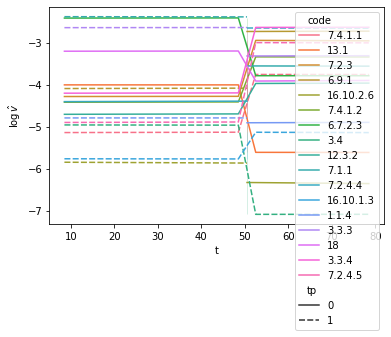

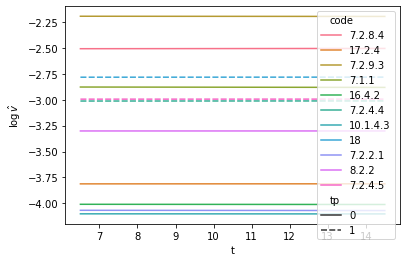

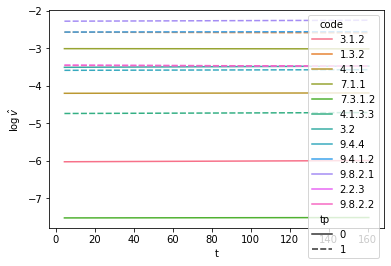

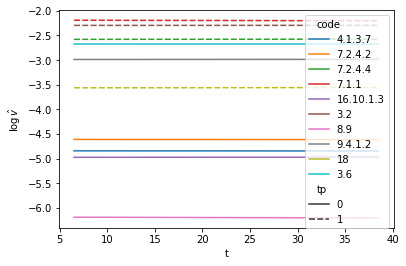

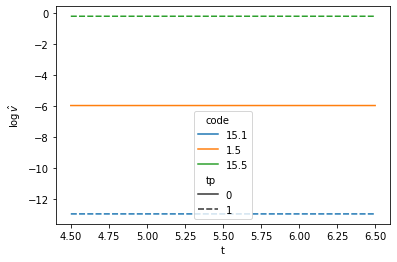

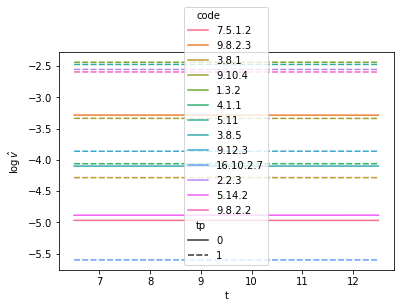

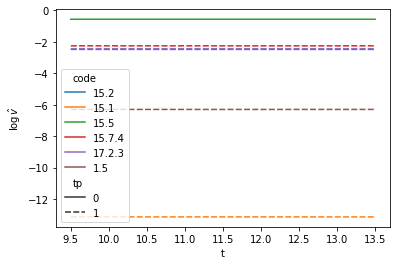

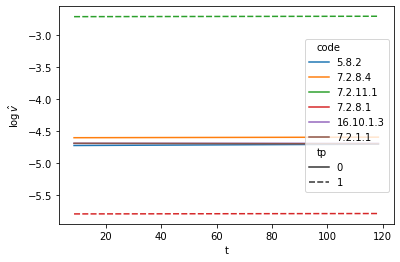

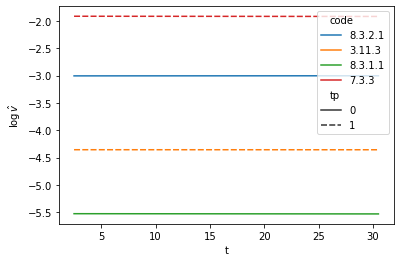

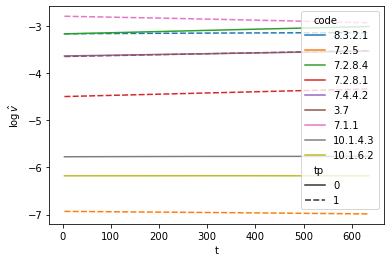

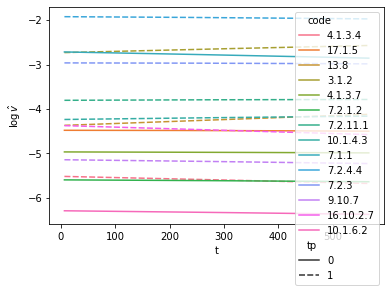

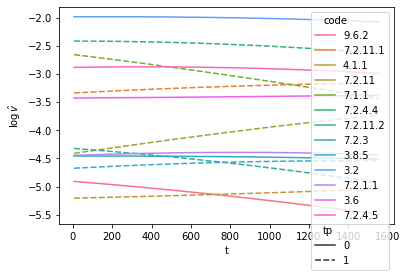

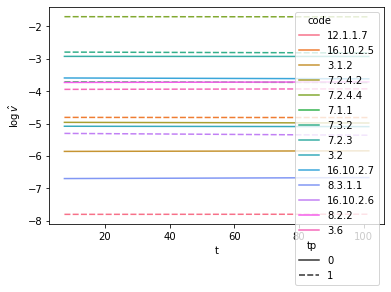

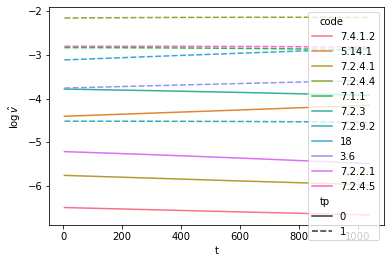

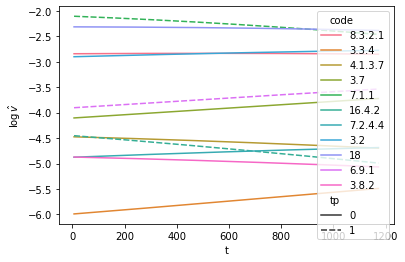

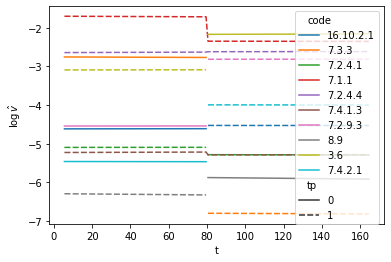

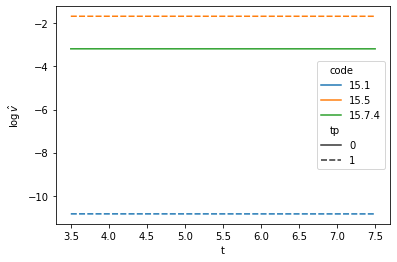

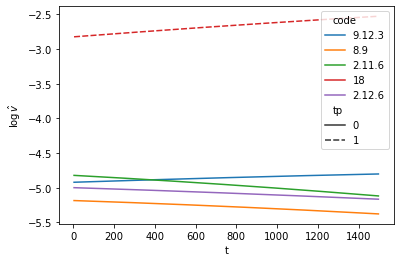

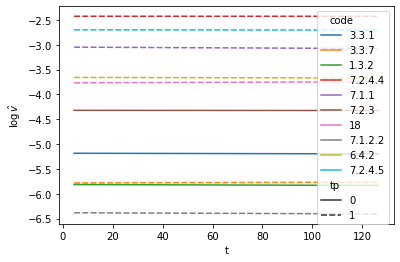

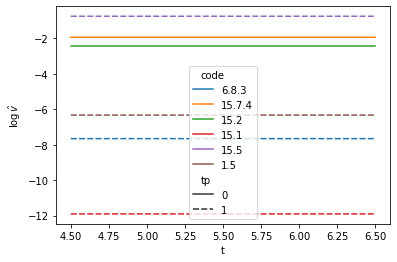

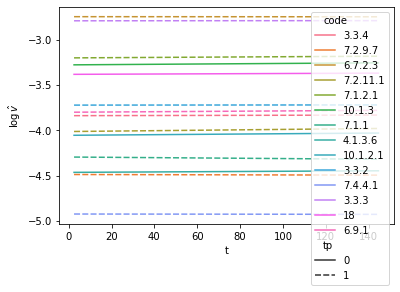

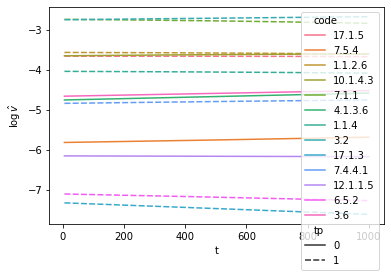

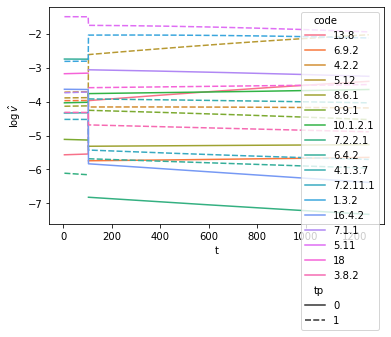

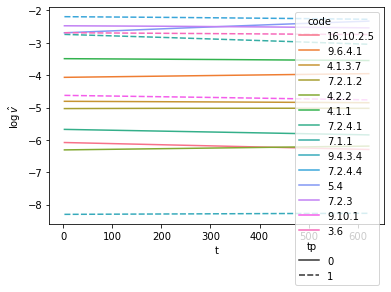

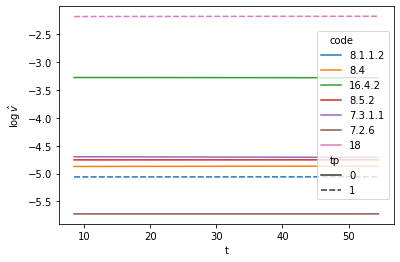

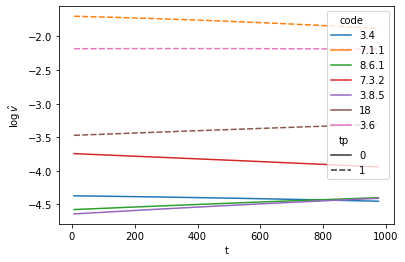

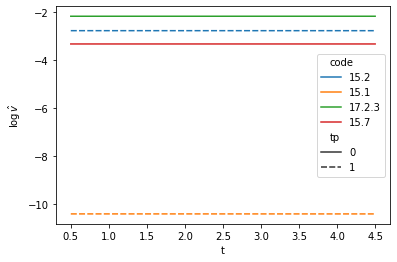

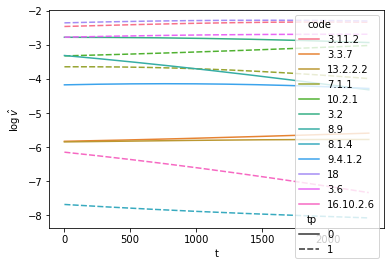

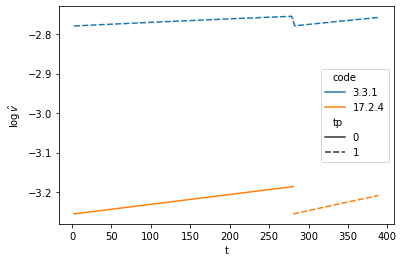

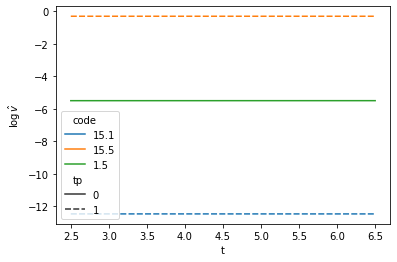

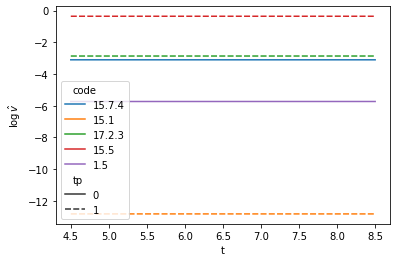

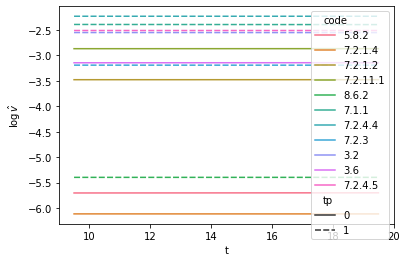

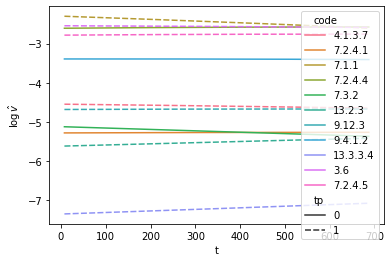

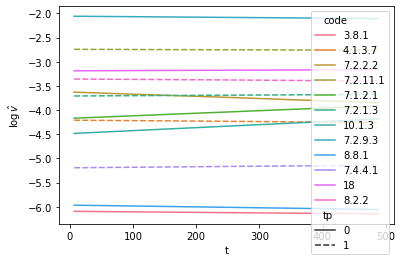

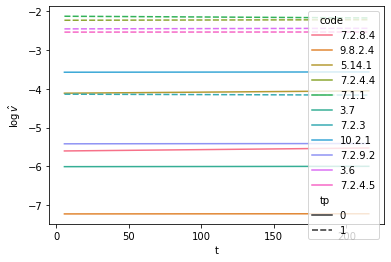

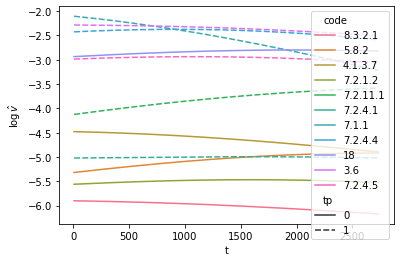

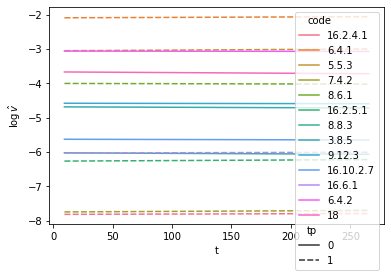

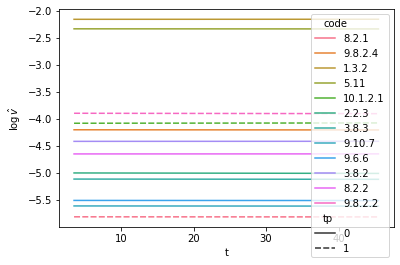

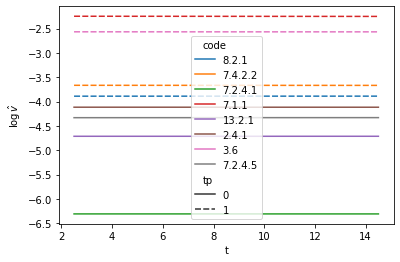

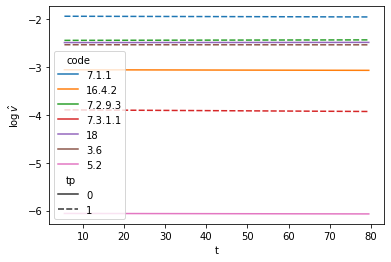

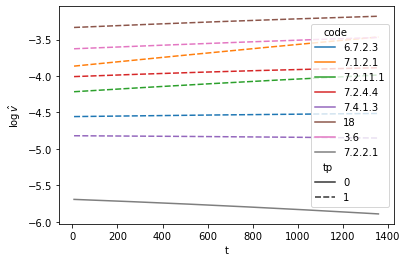

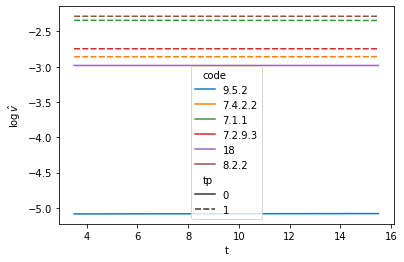

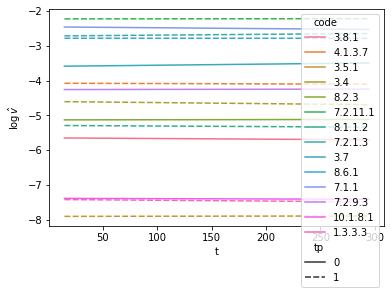

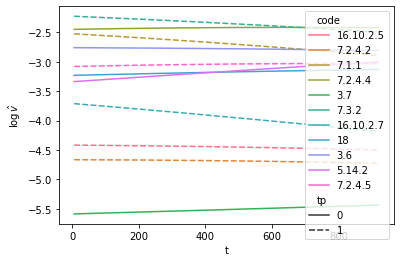

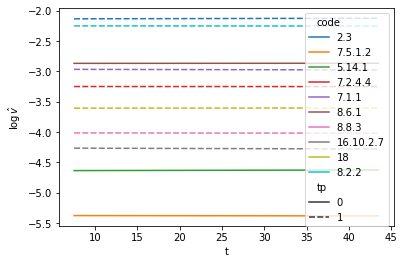

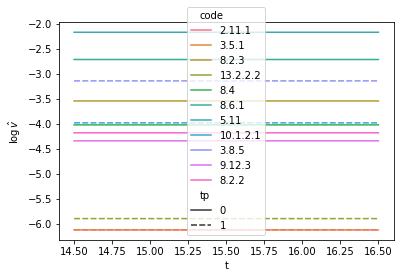

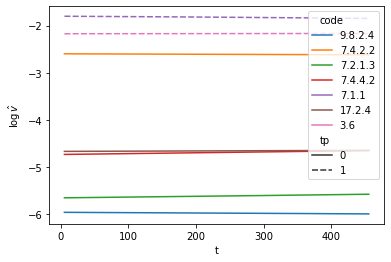

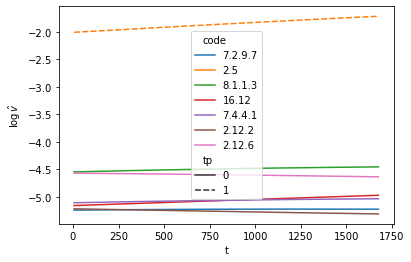

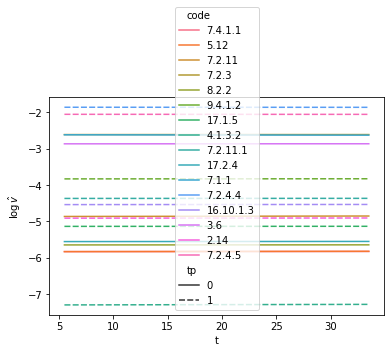

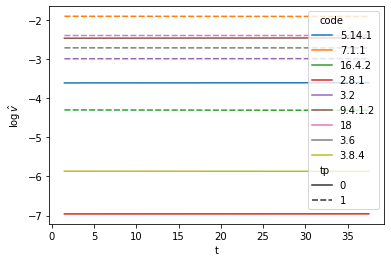

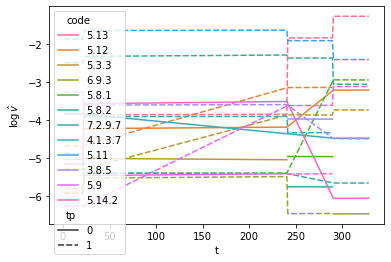

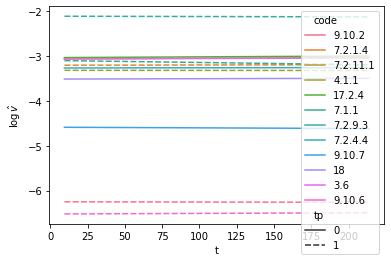

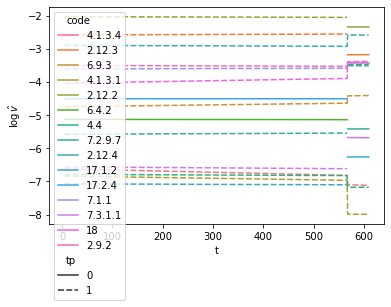

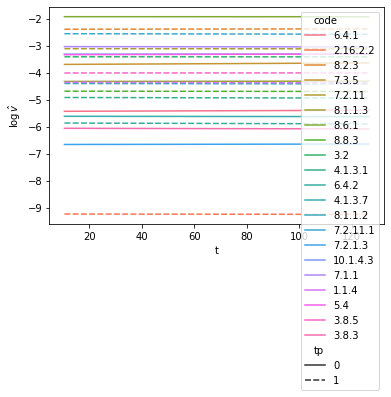

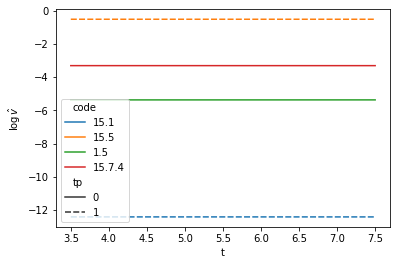

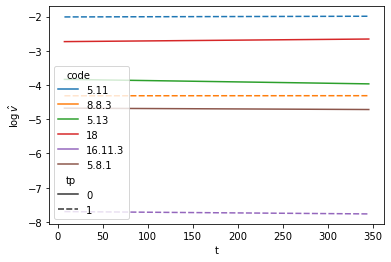

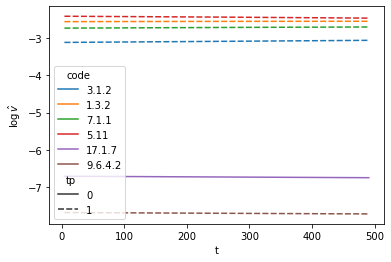

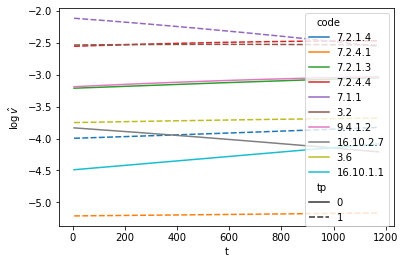

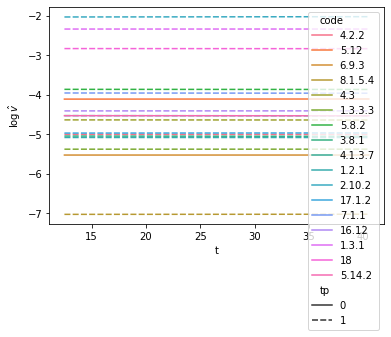

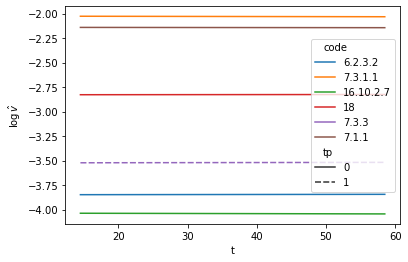

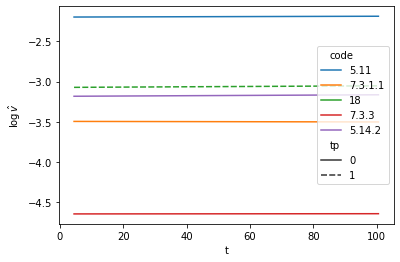

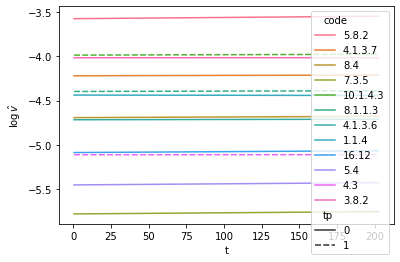

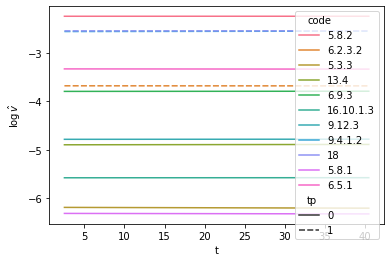

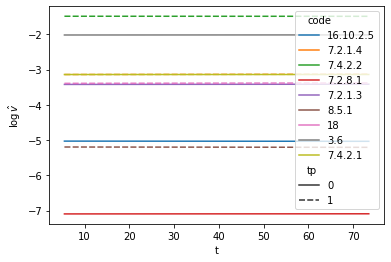

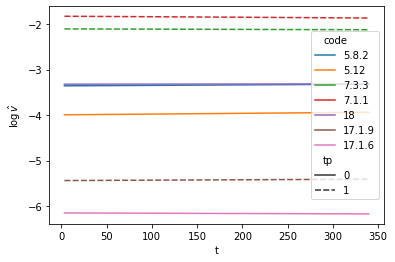

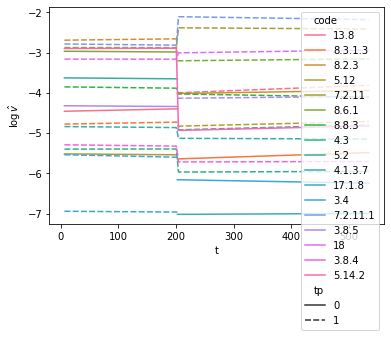

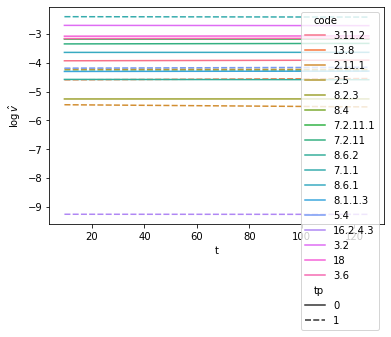

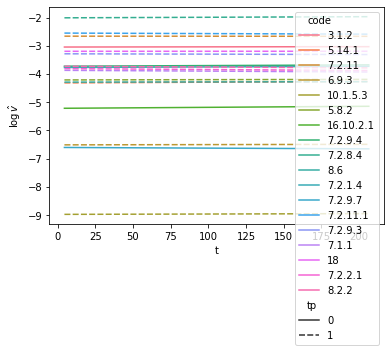

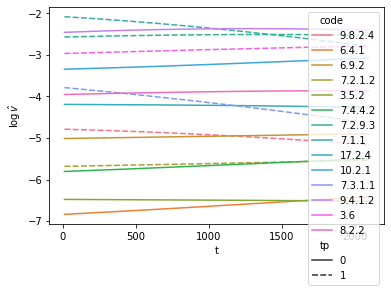

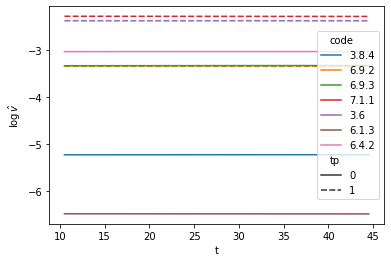

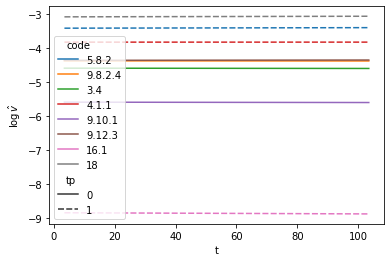

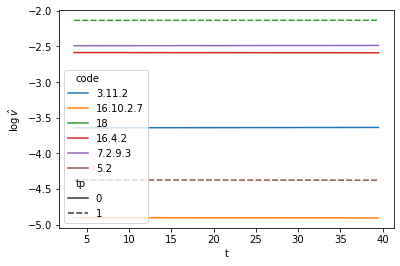

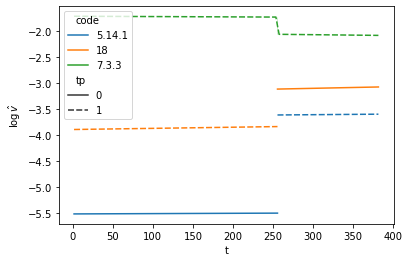

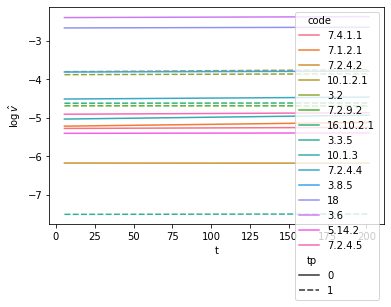

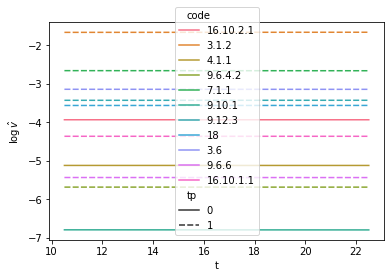

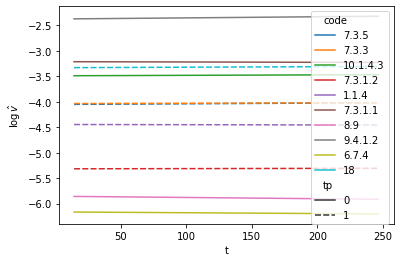

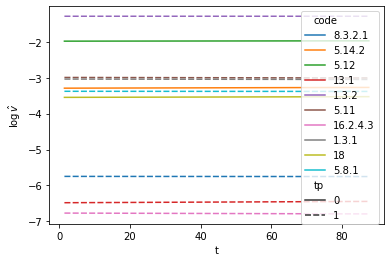

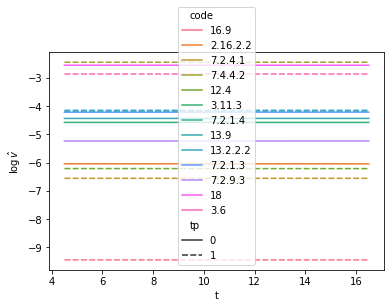

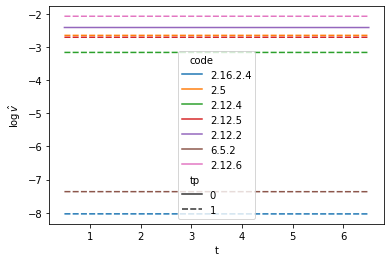

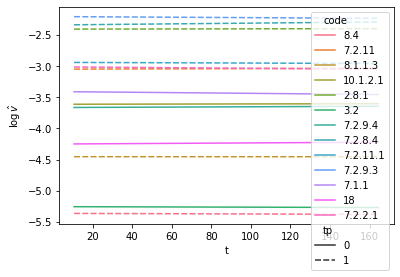

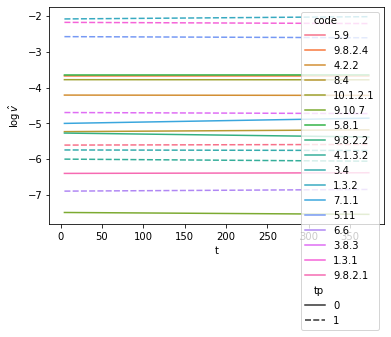

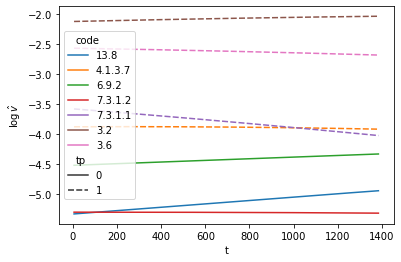

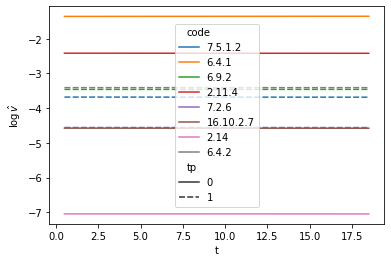

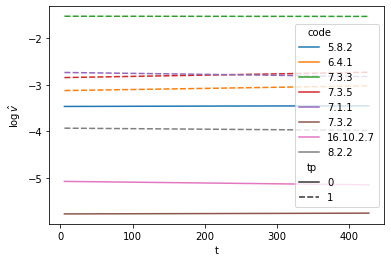

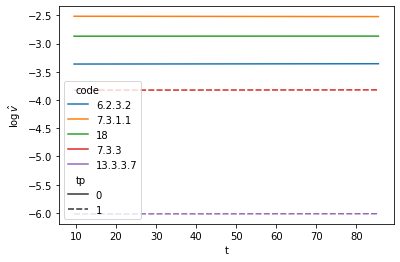

In [152]:
for i in data:
    plt.figure(i)
    sns.lineplot(data=data[i], x="t", y=r'$\log\hat{v}$', hue='code', style='tp')